#### We will Download a Pre-trained model

# Lets download a trained model from TensorFlow detection model zoo

In [3]:
#Get trained model
!wget -q http://download.tensorflow.org/models/object_detection/mask_rcnn_inception_resnet_v2_atrous_coco_2018_01_28.tar.gz

In [3]:
#Unzip the file
!tar -xf mask_rcnn_inception_resnet_v2_atrous_coco_2018_01_28.tar.gz

In [2]:
#check the unzipped files in the folder
!ls -l mask_rcnn_inception_resnet_v2_atrous_coco_2018_01_28

total 1078784
-rw-r--r--  1 sumo  staff         77 Feb  2  2018 checkpoint
-rw-r--r--  1 sumo  staff  266873310 Feb  2  2018 frozen_inference_graph.pb
-rw-r--r--  1 sumo  staff  260030748 Feb  2  2018 model.ckpt.data-00000-of-00001
-rw-r--r--  1 sumo  staff      43391 Feb  2  2018 model.ckpt.index
-rw-r--r--  1 sumo  staff   10496629 Feb  2  2018 model.ckpt.meta
-rw-r--r--  1 sumo  staff       3811 Feb  2  2018 pipeline.config
drwxr-xr-x  4 sumo  staff        128 Feb  2  2018 saved_model


In [3]:
!ls -l mask_rcnn_inception_resnet_v2_atrous_coco_2018_01_28/saved_model

total 525736
-rw-r--r--  1 sumo  staff  267553754 Feb  2  2018 saved_model.pb
drwxr-xr-x  2 sumo  staff         64 Feb  2  2018 variables


#### Load Model

In [4]:
#This code will work with tf 2.x
import tensorflow as tf

In [5]:
#Check the tf version
tf.__version__

'2.7.0'

# Load the model

In [8]:
model = tf.saved_model.load('mask_rcnn_inception_resnet_v2_atrous_coco_2018_01_28/saved_model')
model = model.signatures['serving_default']

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


# check the model's input and output

In [10]:
model.inputs

[<tf.Tensor 'image_tensor:0' shape=(None, None, None, 3) dtype=uint8>]

In [11]:
model.outputs

[<tf.Tensor 'detection_boxes:0' shape=(None, 100, 4) dtype=float32>,
 <tf.Tensor 'detection_classes:0' shape=(None, 100) dtype=float32>,
 <tf.Tensor 'detection_masks:0' shape=(None, None, 33, 33) dtype=float32>,
 <tf.Tensor 'detection_scores:0' shape=(None, 100) dtype=float32>,
 <tf.Tensor 'num_detections:0' shape=(None,) dtype=float32>]

# Outputs

How to understand 4 outputs here:



1.   **num_detections** : Number of prediction boxes we are getting from our model. We limit number of predictions in model configuration file. In this model, output will have top 100 predictions (out of 1000s of anchor boxes). Please note that we get this output after Non-Maximum supression (NMS) step has been completed.
2.   **detection_classes** : Index of the class with highest probability for each predicted box. These index values should be matched with index created using Label Encoder during training time. The values will between 1 to number of classes.
3.   **detection_scores** : Probability value for highest probability class for each box. The value will be between 0 to 1. This indicates how confident model of a real object in the box.
4.   **detection_boxes** : Boundary box co-ordinates for each predicted box. For each predicted box, we get 4 outputs i.e ymin, xmin, ymax, xmax. Please note that these are normalized values.

5. **detection_masks** : Masks for each detected box



#### Load Class labels

Label dictionary (class index to class name mapping) should be taken from training module. Here is the dictionary which was used for this model.

In [12]:
all_classes = {1 : 'person' , 2: 'bicycle' , 3: 'car' , 4: 'motorcycle' , 5: 'airplane' , 6: 'bus' , 7: 'train' , 
               8: 'truck' , 9: 'boat' , 10: 'traffic light' , 11: 'fire hydrant' , 13: 'stop sign' , 14: 'parking meter' , 
               15: 'bench' , 16: 'bird' , 17: 'cat' , 18: 'dog' , 19: 'horse' , 20: 'sheep' , 21: 'cow' , 22: 'elephant' , 
               23: 'bear' , 24: 'zebra' , 25: 'giraffe' , 27: 'backpack' , 28: 'umbrella' , 31: 'handbag' , 32: 'tie' , 
               33: 'suitcase' , 34: 'frisbee' , 35: 'skis' , 36: 'snowboard' , 37: 'sports ball' , 38: 'kite' , 
               39: 'baseball bat' , 40: 'baseball glove' , 41: 'skateboard' , 42: 'surfboard' , 43: 'tennis racket' , 
               44: 'bottle' , 46: 'wine glass' , 47: 'cup' , 48: 'fork' , 49: 'knife' , 50: 'spoon' , 51: 'bowl' , 
               52: 'banana' , 53: 'apple' , 54: 'sandwich' , 55: 'orange' , 56: 'broccoli' , 57: 'carrot' , 58: 'hot dog' , 
               59: 'pizza' , 60: 'donut' , 61: 'cake' , 62: 'chair' , 63: 'couch' , 64: 'potted plant' , 65: 'bed' , 
               67: 'dining table' , 70: 'toilet' , 72: 'tv' , 73: 'laptop' , 74: 'mouse' , 75: 'remote' , 76: 'keyboard' , 
               77: 'cell phone' , 78: 'microwave' , 79: 'oven' , 80: 'toaster' , 81: 'sink' , 82: 'refrigerator' , 
               84: 'book' , 85: 'clock' , 86: 'vase' , 87: 'scissors' , 88: 'teddy bear' , 89: 'hair drier' , 90: 'toothbrush'}

In [13]:
all_classes[1]

'person'

#### Model Prediction

In [14]:
def reframe_box_masks_to_image_masks(box_masks, boxes, image_height, image_width):
  """
  Code taken from TensorFlow Object Detection API --> utils/visualization_utils.py 
  Transforms the box masks back to full image masks.
  Embeds masks in bounding boxes of larger masks whose shapes correspond to
  image shape.
  Args:
    box_masks: A tf.float32 tensor of size [num_masks, mask_height, mask_width].
    boxes: A tf.float32 tensor of size [num_masks, 4] containing the box
           corners. Row i contains [ymin, xmin, ymax, xmax] of the box
           corresponding to mask i. Note that the box corners are in
           normalized coordinates.
    image_height: Image height. The output mask will have the same height as
                  the image height.
    image_width: Image width. The output mask will have the same width as the
                 image width.
  Returns:
    A tf.float32 tensor of size [num_masks, image_height, image_width].
  """
  def reframe_box_masks_to_image_masks_default():
    """The default function when there are more than 0 box masks."""
    def transform_boxes_relative_to_boxes(boxes, reference_boxes):
      boxes = tf.reshape(boxes, [-1, 2, 2])
      min_corner = tf.expand_dims(reference_boxes[:, 0:2], 1)
      max_corner = tf.expand_dims(reference_boxes[:, 2:4], 1)
      transformed_boxes = (boxes - min_corner) / (max_corner - min_corner)
      return tf.reshape(transformed_boxes, [-1, 4])

    box_masks_expanded = tf.expand_dims(box_masks, axis=3)
    num_boxes = tf.shape(box_masks_expanded)[0]
    unit_boxes = tf.concat(
        [tf.zeros([num_boxes, 2]), tf.ones([num_boxes, 2])], axis=1)
    reverse_boxes = transform_boxes_relative_to_boxes(unit_boxes, boxes)
    return tf.image.crop_and_resize(
        image=box_masks_expanded,
        boxes=reverse_boxes,
        box_indices=tf.range(num_boxes),
        crop_size=[image_height, image_width],
        extrapolation_value=0.0)
  image_masks = tf.cond(
      tf.shape(box_masks)[0] > 0,
      reframe_box_masks_to_image_masks_default,
      lambda: tf.zeros([0, image_height, image_width, 1], dtype=tf.float32))
  return tf.squeeze(image_masks, axis=3)

# Write the Prediction code

In [19]:
#Function to get predictions from a Detection model
def detector_prediction(image_file, confidence_threshold=0.5):
    '''
    image_file : image file to run the detections on
    confidence_threshold:  min probability that should be met to call it a detection of partcilar object
    '''
    #load the image
    img = tf.keras.preprocessing.image.load_img(image_file)
    w, h = img.size
    
    #convert the image to a numpy array
    img_array = tf.keras.preprocessing.image.img_to_array(img).astype('uint8')
    
    #add the batch dimensions
    img_array = tf.expand_dims(img_array, axis=0)
    
    #Run prediction
    output = model(img_array)
    
    #get the detection scores
    detection_scores = output['detection_scores'].numpy()[0]
    #get the detection_classes
    detection_classes = output['detection_classes'].numpy()[0]
    #get the rectangular detection boxes locations
    detection_boxes = output['detection_boxes'].numpy()[0]
    #get the detection masks
    detection_masks = output['detection_masks'].numpy()[0]
    
    
    #select predictions for which the probability of detection is higher than the confidence threshold
    selected_predictions = detection_scores >= confidence_threshold
    selected_prediction_scores = detection_scores[selected_predictions]
    selected_prediction_classes = detection_classes[selected_predictions]
    selected_prediction_boxes = detection_boxes[selected_predictions]
    selected_prediction_masks = detection_masks[selected_predictions]
    
    #resize masks to image size
    detection_masks_reframed = reframe_box_masks_to_image_masks(selected_prediction_masks,selected_prediction_boxes,h,w)
    
    #make it a binary array
    detection_masks_reframed = tf.cast(detection_masks_reframed>0.5, tf.uint8)
    
    #denormalize the box coordinates
    img_w, img_h = img.size
    
    for i in range (selected_prediction_boxes.shape[0]):
        selected_prediction_boxes[i,0] *= img_h # ymin
        selected_prediction_boxes[i,1] *= img_w # xmin
        selected_prediction_boxes[i,2] *= img_h # ymax
        selected_prediction_boxes[i,3] *= img_w # xmax
        
    #Make all corordinate as integer pixel values
    selected_prediction_boxes = selected_prediction_boxes.astype(int)
    
    #Convert the class label ( in integers) to its text labels
    predicted_classes = []
    for i in range(selected_prediction_classes.shape[0]):
        predicted_classes.append(all_classes[int(selected_prediction_classes[i])])
    #number of predictions
    selected_num_predictions = selected_prediction_boxes.shape[0]
    
    #Return all predictions
    return { 'Total Predictions' : selected_num_predictions,
             'Scores' : selected_prediction_scores,
             'Classes' : predicted_classes,
             'Box_coordinates': selected_prediction_boxes,
             'Masks' : detection_masks_reframed }

Let's download couple of images for which we will do predictions.

In [15]:
!wget https://github.com/tensorflow/models/raw/master/research/object_detection/test_images/image1.jpg --quiet
!wget https://github.com/tensorflow/models/raw/master/research/object_detection/test_images/image2.jpg --quiet

In [16]:
!ls -l

total 1562016
-rw-rw-r--@ 1 sumo  staff    9045726 Nov 20 14:06 1. Mask RCNN - TensorFlow Object Detection API.ipynb
-rw-rw-r--@ 1 sumo  staff   19709554 Nov 20 18:13 1. Object_Detection_E2E_TF2.ipynb
-rw-rw-r--@ 1 sumo  staff    2014906 May 30 08:29 2. Model Prediction _ Pre-trained Model.ipynb
-rw-rw-r--@ 1 sumo  staff     211614 Apr 20  2021 Aircraft Carrier.jpg
-rw-rw-r--@ 1 sumo  staff     700190 Apr 20  2021 Airplane.jpg
-rw-rw-r--@ 1 sumo  staff     169683 Apr 20  2021 Airport Crowd.jpg
-rw-rw-r--@ 1 sumo  staff      39677 Apr 20  2021 Fighter Jet.jpg
-rw-rw-r--@ 1 sumo  staff      39192 Apr 16  2021 Group Photo.jpeg
-rw-rw-r--@ 1 sumo  staff     535011 Apr 20  2021 Group Photo.jpg
-rw-r--r--  1 sumo  staff      25652 Nov 21 20:19 Object-detection-exercise-AdvCV.ipynb
-rw-rw-r--@ 1 sumo  staff     896127 May 30 09:58 Semantic Segmentation using UNET_ TGS multi.ipynb
-rw-rw-r--@ 1 sumo  staff   26337872 Apr 15  2021 TGS_v1.h5
-rw-r--r--  1 sumo  staff     129862 Nov 20 12:19 imag

In [ ]:
#Lets view the images we are using for detection

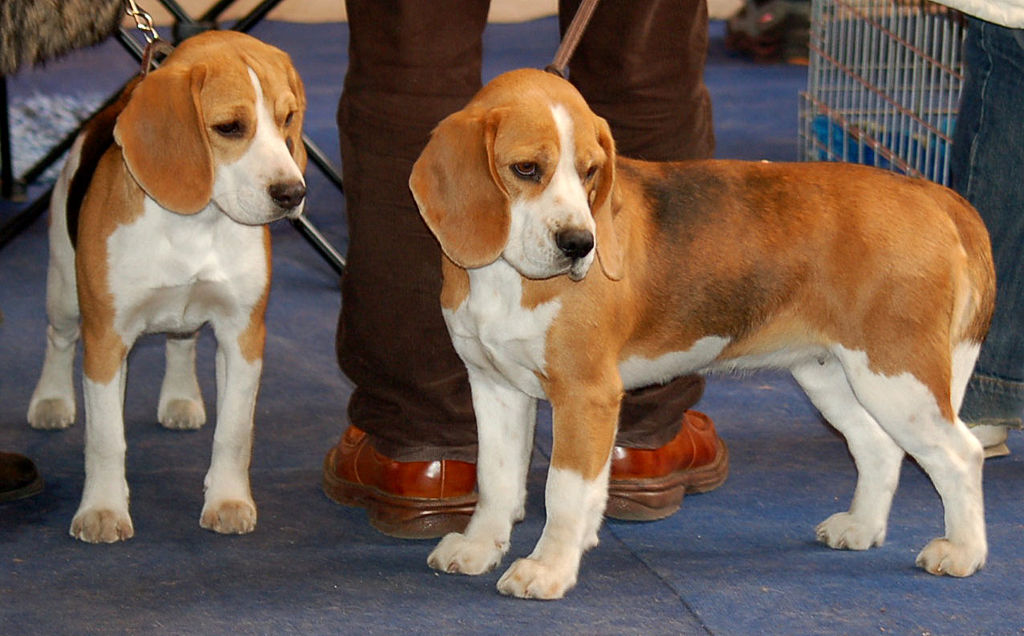

In [17]:
tf.keras.preprocessing.image.load_img('image1.jpg')

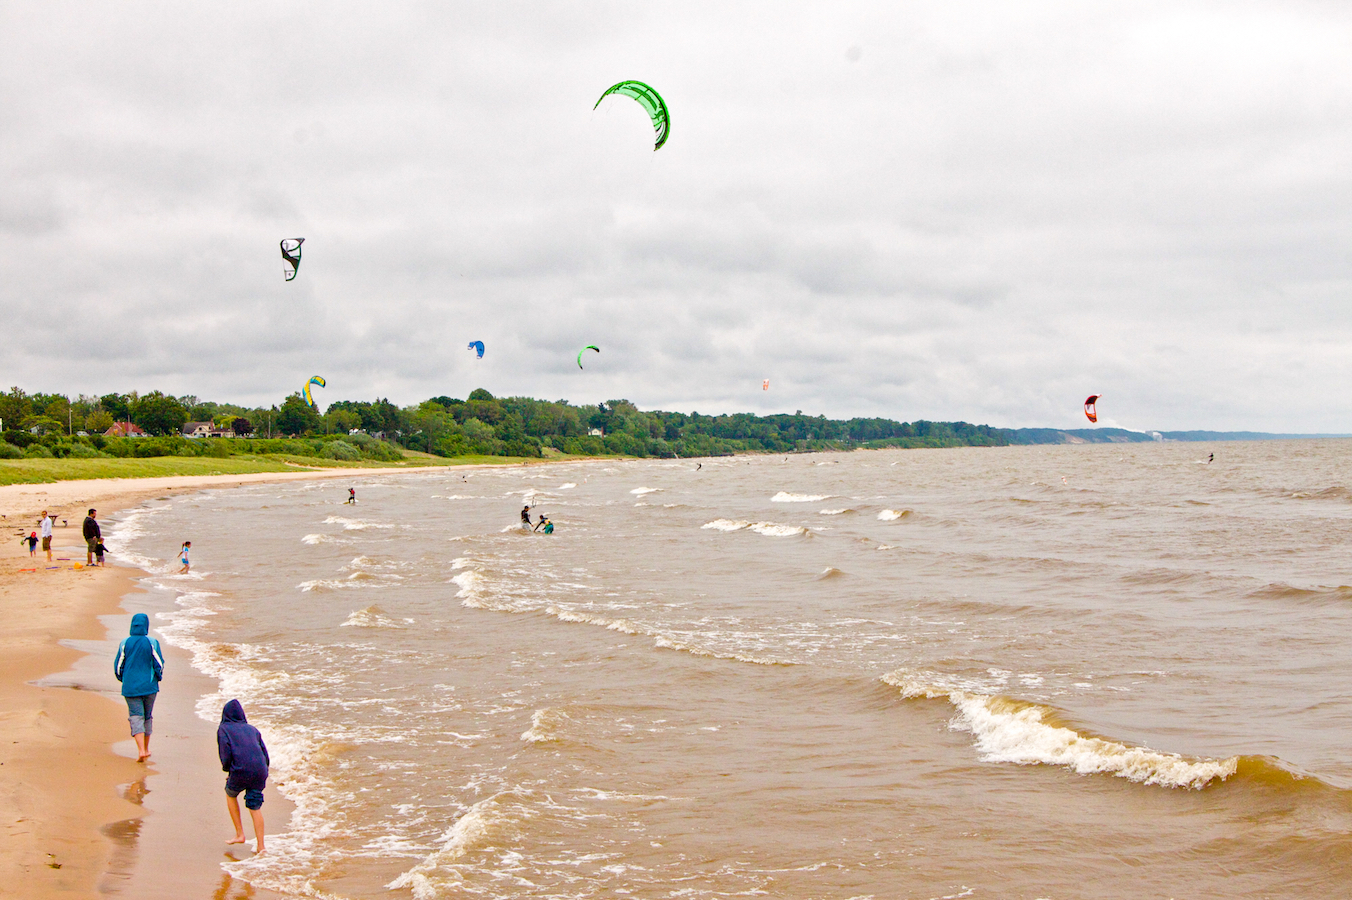

In [18]:
tf.keras.preprocessing.image.load_img('image2.jpg')

In [ ]:
#Lets run the predictions

In [20]:
detector_prediction('image1.jpg')

{'Total Predictions': 5,
 'Scores': array([0.9996006, 0.998021 , 0.9629081, 0.7772577, 0.7385769],
       dtype=float32),
 'Classes': ['dog', 'dog', 'person', 'person', 'person'],
 'Box_coordinates': array([[  28,   28,  539,  311],
        [  72,  390,  602, 1017],
        [   0,  213,  528,  706],
        [   0,  402,  165,  702],
        [   1,  546,  164,  721]]),
 'Masks': <tf.Tensor: shape=(5, 636, 1024), dtype=uint8, numpy=
 array([[[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         ...,
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0]],
 
        [[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         ...,
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0]],
 
        [[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         ...,
       

#### Visualizing Model Prediction

In [22]:
import cv2
from matplotlib import pyplot as plt
import numpy as np

In [24]:
def visualize_output(image_file, confidence_threshold=0.5):
    
    #call model prediction code we wrote
    output = detector_prediction(image_file, confidence_threshold=confidence_threshold)
    
    #read the image passed
    img = cv2.imread(image_file)
    
    #Draw rectangles for predicted boxes, also lets add the predicted classes
    for i in range(output['Box_coordinates'].shape[0]):
        
        #read the maks
        mask = output['Masks'][i]
        
        #draw the mask
        colored_mask = np.expand_dims(mask, axis=2)*np.reshape([255,255,0],(1,1,3))
        img = cv2.addWeighted(colored_mask.astype('uint8'), 0.5, img, 1.0,0)
        
        #read the bounding box
        box = output['Box_coordinates'][i]
        
        #Draw rectange
        img = cv2.rectangle(img,(box[1],box[0]),(box[3], box[2]),(0,255,0),2)
        
        #Add Labels classname and confidence levels
        label = output['Classes'][i] + ":" + str(round(output['Scores'][i],2))
        img = cv2.putText(img, label, (box[1], box[0]-10), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
        
    #convert BGR format to RGB to use with matplotlib
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    #Display image
    plt.figure(figsize=(12,8))
    plt.imshow(img)
    plt.show()

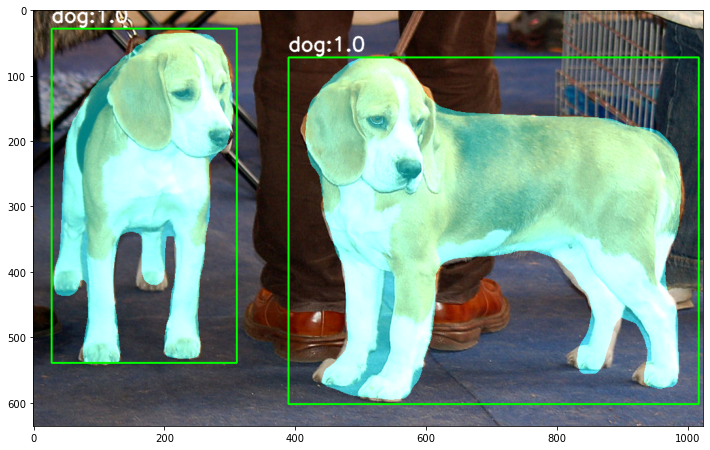

In [26]:
visualize_output('image1.jpg', confidence_threshold=0.99)

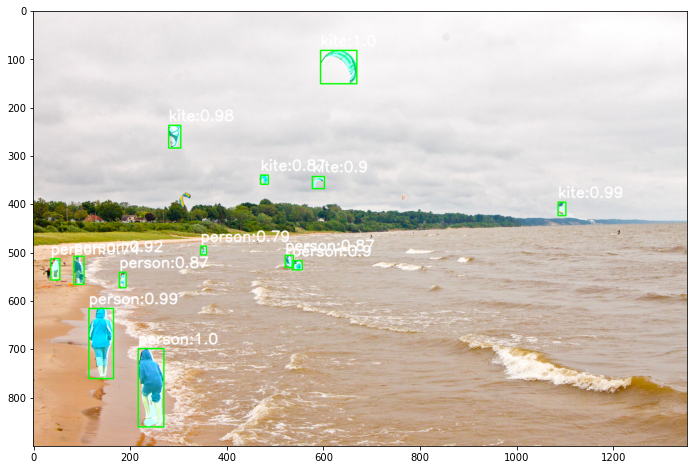

In [27]:
visualize_output('image2.jpg', confidence_threshold=0.5)

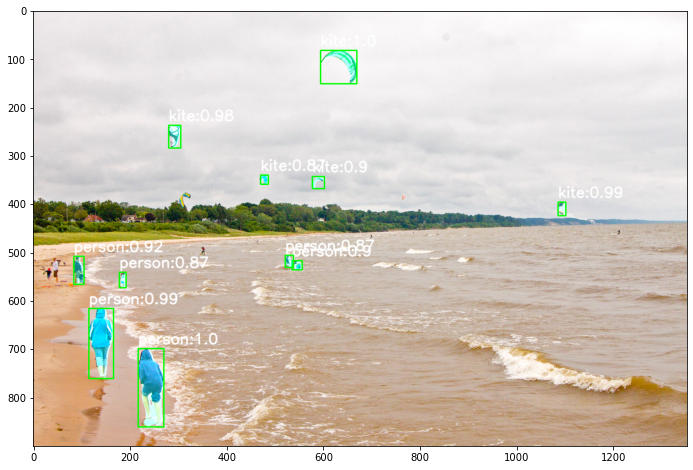

In [28]:
visualize_output('image2.jpg', confidence_threshold=0.8)

# Extracting Object(s) from an Image

Function to extract object(s) based on predicted boxes

In [31]:
def extract_object_from_box(image_file, object_name, confidence_threshold=0.5):
    
    #Call model prediction
    output = detector_prediction(image_file, confidence_threshold=confidence_threshold)
    
    #read the image passed
    img = cv2.imread(image_file)
    
    cropped_images = []

    #Draw rectange for predicted boxes
        
    for i in range(output['Box_coordinates'].shape[0]):
 
        #classes
        label = output['Classes'][i]
        if label.lower() == object_name.lower():
            
            #read the bounding box
            box = output['Box_coordinates'][i]
            
            cropped_img = img[box[0]: box[2], box[1]:box[3]]
            cropped_images.append(cropped_img)
            
            
    if (len(cropped_images)==0):
        print('No '+ object_name + ' found ')
        return
    
    print('Number of  '+ object_name + ' found ', len(cropped_images) )
    plt.figure(figsize=(15,10))
    for i in range(len(cropped_images)):
        plt.subplot(1,len(cropped_images), i+1)
        plt.imshow(cv2.cvtColor(cropped_images[i], cv2.COLOR_BGR2RGB))
        
    plt.show()

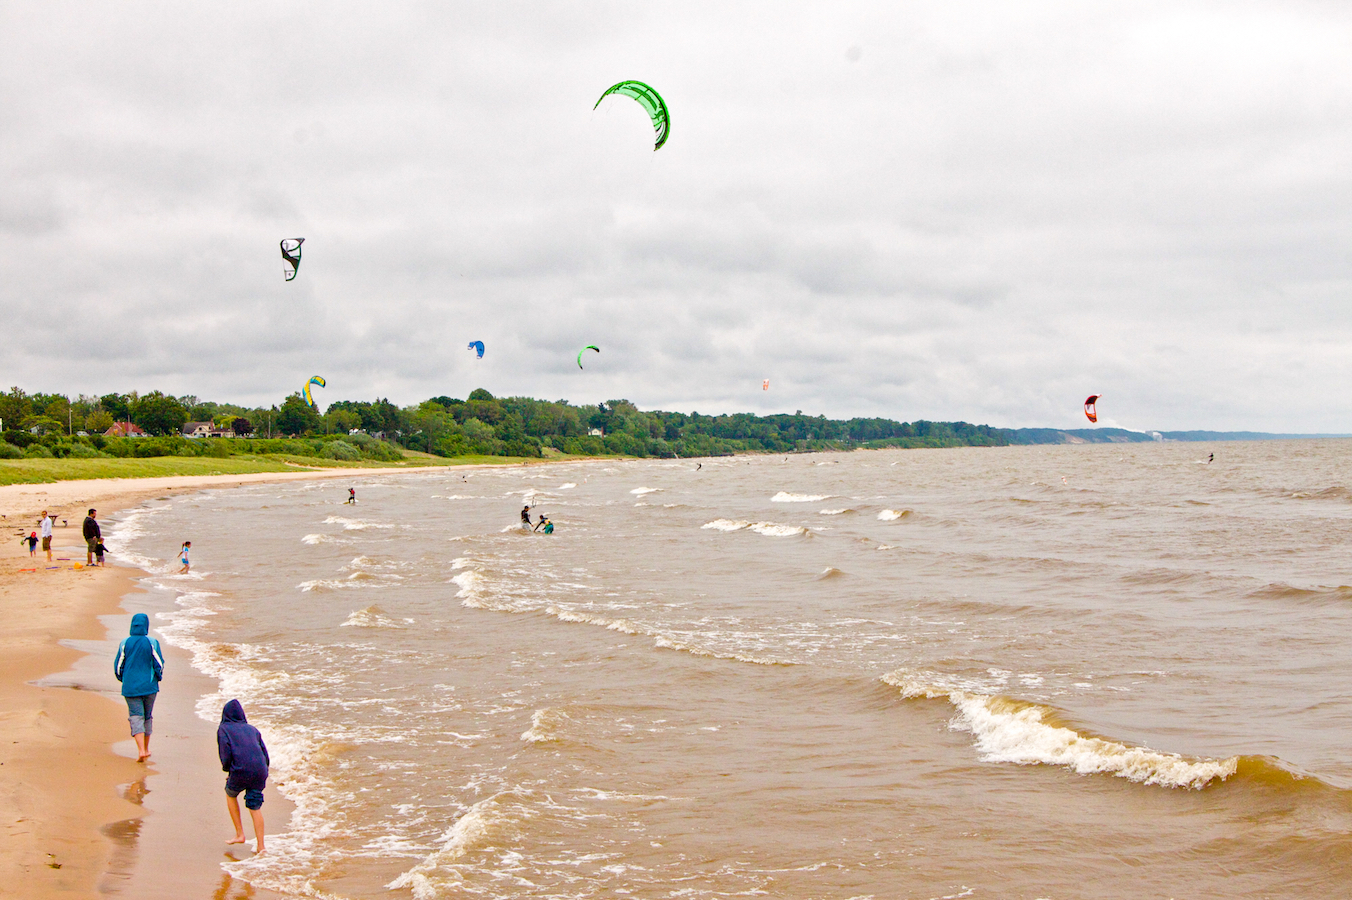

In [33]:
tf.keras.preprocessing.image.load_img('image2.jpg')

Number of  person found  8


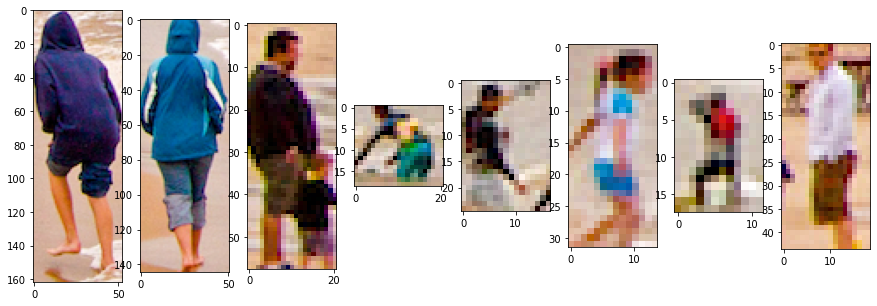

In [32]:
extract_object_from_box('image2.jpg', 'person')

Number of  kite found  3


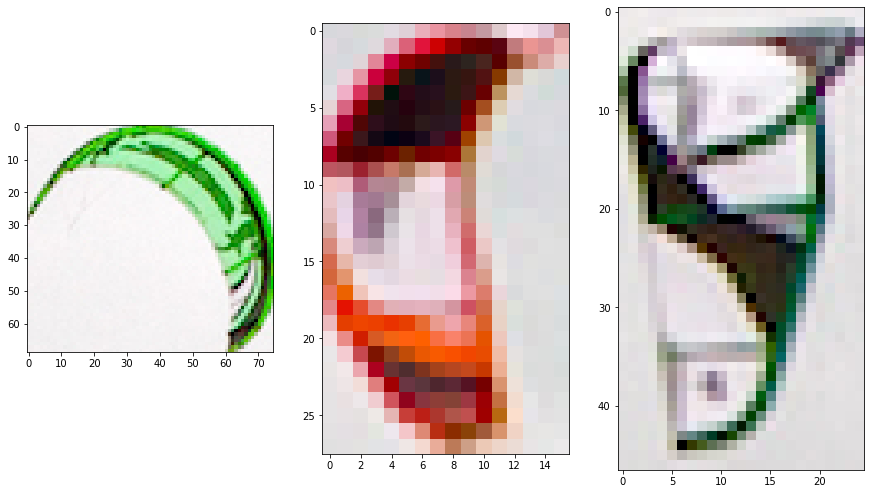

In [37]:
extract_object_from_box('image2.jpg', 'kite',0.98)

# Function to extract object(s) based on the mask 

In [27]:
def extract_object_from_mask(image_file, object_name, confidence_threshold=0.5):
    #call model prediction function we defined
    output= detector_prediction(image_file, confidence_threshold=confidence_threshold)
    
    #read the image file
    img = cv2.imread(image_file)
    
    cropped_images =[]
    
    #Draw rectangle for predicted boxes, also add the predicted classes
    for i in range(output['Box_coordinates'].shape[0]): 
        #read the class 
        label = output['Classes'][i]
        
        if label.lower() == object_name.lower():
            
            
            #Mask 
            mask = output['Mask'][i].numpy()
            #print('Mask detected ==>shape: ', mask.shape)
            #print('Mask itselfabs ', mask)
            print('250th row: ', mask[250, :300])
            print('250th row: ', mask[250, 300:650])
            print('250th row: ', mask[250, 650: ])
            
            mask np.repeat[np.expand_dims(mask, axis=2), 3, axis=-1]*255 
            
            #crop image 
            cropped_img = cv2.bitwise_and(img, mask)
            cropped_images.append(cropped_img)
            
    if len(cropped_images) ==0:
        print('No ' + object_name + "found ")
        return
    
    print('No ' + object_name + "found ", len(cropped_images))
    plt.figure(figsize=(15, 10))
    
    
    for i in range(len(cropped_images)):
        plt.subplot(1, len(cropped_images), i+1) 
        plt.imshow(cv2.cvtColor(cropped_images[i], cv2.COLOR_BGR2RGB)) 
        
    plt.show()


# Extract objects from different images